# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src="images/crisp.png" width="50%" />
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

#### Context and objective

The used car market is one of the largest in the world. Used cars are in high demand because they are typically sold at discounted prices while remaining usable. As a rule, the sale price of a used car depends on its age and mileage. However, there may be other factors that affect the price.

In this exercise, a used car dealership wishes to develop a model to analyze used car sales. Such a model can be used to identify important features that affect the price of a used car, and predict prices accordingly. In some cases, the business may be able to take action to increase a car's value. For example, if red cars tend to sell for more, then the dealer could repaint a car to get better offers from potential buyers.

In [ ]:
# import required modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
# set up environment and connect to Google Drive
import os

from google.colab import drive

drive_root = '/content/drive'
if not os.path.exists(drive_root):
  drive.mount(drive_root)

colab_home = f'{drive_root}/MyDrive/Colab'
ws = f'{colab_home}/workspace_ucb_ml'

os.chdir(ws)

Mounted at /content/drive


In [ ]:
# load data from .csv file
df = pd.read_csv('data/vehicles.csv')

In [ ]:
# verify data is loaded correctly
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Data dictionary

We first explore the data types.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

The data set contains 17 features:

* `id` - the sale ID
* `region` - the region in which the sale took place
* `price` - the sale price. **Target variable**
* `year` - assumed to be model year
* `manufacturer` - the brand
* `model` - a brief description of the vehicle
* `condition` - the vehicle's condition
* `cylinders` - the number of cylinders in the engine
* `fuel` - the vehicle's power source
* `odometer` - the car's mileage, assumed to be miles based on the locations in the data set
* `title_status` - the branded title
* `VIN` - vehicle identification number
* `drive` - drive wheel type
* `size` - vehicle size class
* `type` - the vehicle type
* `paint_color` - the color of the automotive paint
* `state` - the state where the vehicle was sold

Only the sale price and mileage are continuous; all other features are discrete.

In [ ]:
# count null values
df.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [ ]:
# count duplicated values
df.duplicated().sum()

0

**Observations**

* Only four features have complete data:
  * ID
  * Region
  * Price
  * State
* Some features are missing numerous values
* Data contains no duplicate rows

During the data cleaning process, the columns with missing data will be handled on a case-by-case basis

In [ ]:
# get summary statistics of continuous variables
numerical_vars = ['price', 'odometer']
df[numerical_vars].describe()

,price,odometer
count,4.268800e+05,4.224800e+05
mean,7.519903e+04,9.804333e+04
std,1.218228e+07,2.138815e+05
min,0.000000e+00,0.000000e+00
25%,5.900000e+03,3.770400e+04
50%,1.395000e+04,8.554800e+04
75%,2.648575e+04,1.335425e+05
max,3.736929e+09,1.000000e+07


In [ ]:
# get the median values for later use
median_price_static = df['price'].median()
median_mileage_static = df['odometer'].median()

**Observations**

The data contains obvious outliers. For example, the highest sale price is listed as \$3.7 billion while the [most expensive car ever sold at an auction](https://en.wikipedia.org/wiki/List_of_most_expensive_cars_sold_at_auction#Absolute_record) was "only" \$143 million. Outliers will be handled during the data cleaning process.

#### Data visualization

We plot the data to get a better understanding of the distributions. Our first stop is to create histograms of the sale price and mileage.

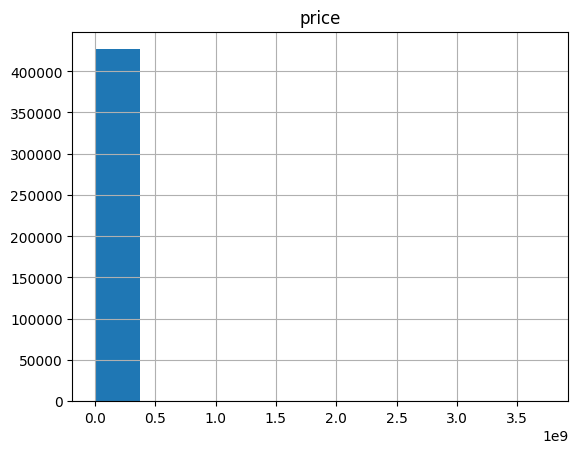

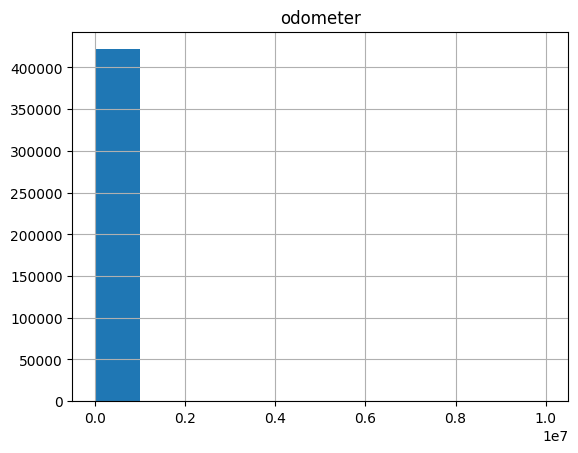

In [ ]:
for var in numerical_vars:
  df[var].hist()
  plt.title(var)
  plt.show()

As it is difficult to see the distribution of outliers, the above is repeated using a logarithmic scale.

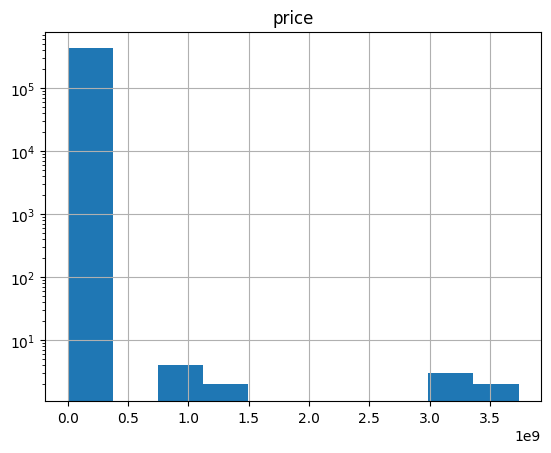

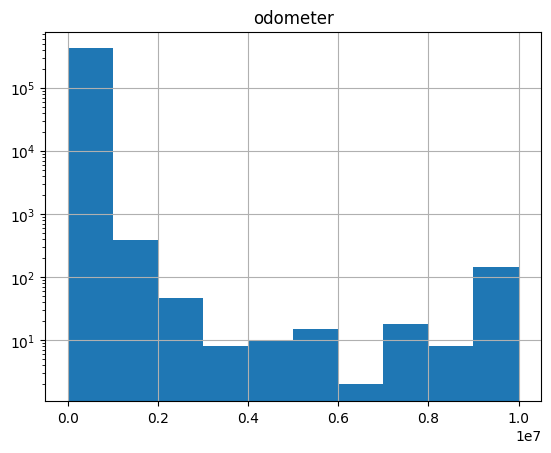

In [ ]:
for var in numerical_vars:
  df[var].hist(log=True)
  plt.title(var)
  plt.show()

Box plots can also be used to visually detect outliers.

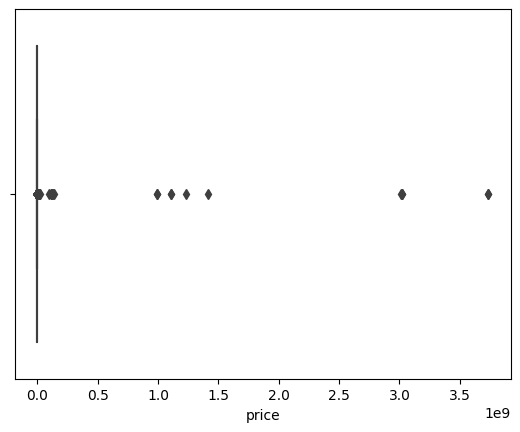

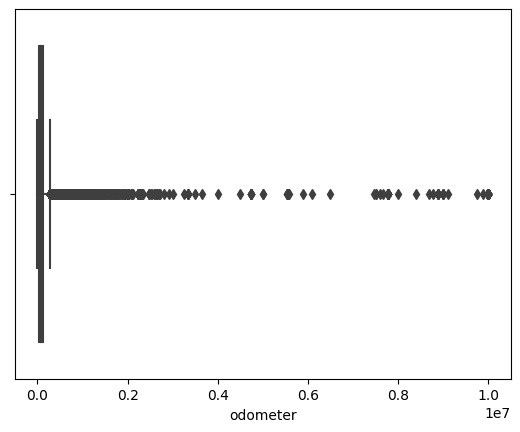

In [ ]:
for var in numerical_vars:
  sns.boxplot(data=df, x=var)
  plt.show()

Count plots are often used to visualize the distributions of categorical variables.

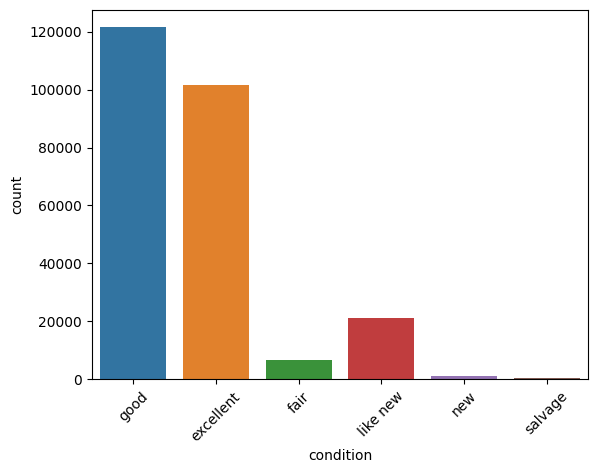

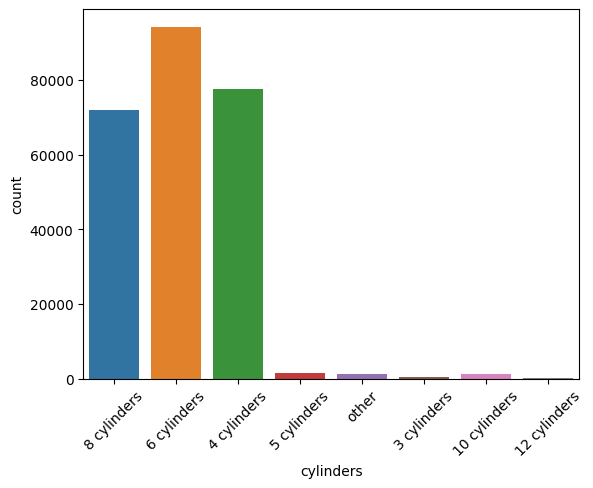

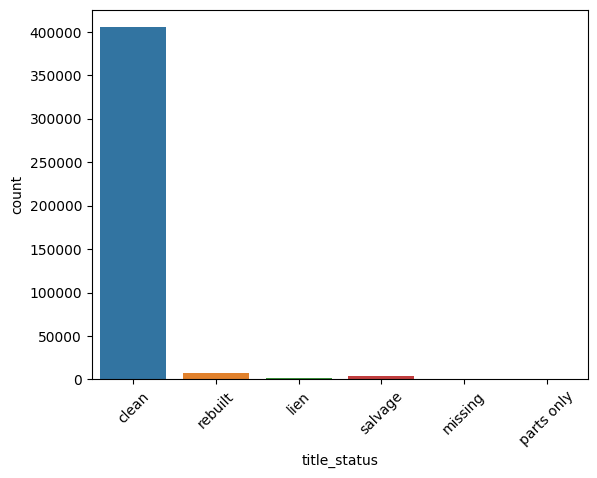

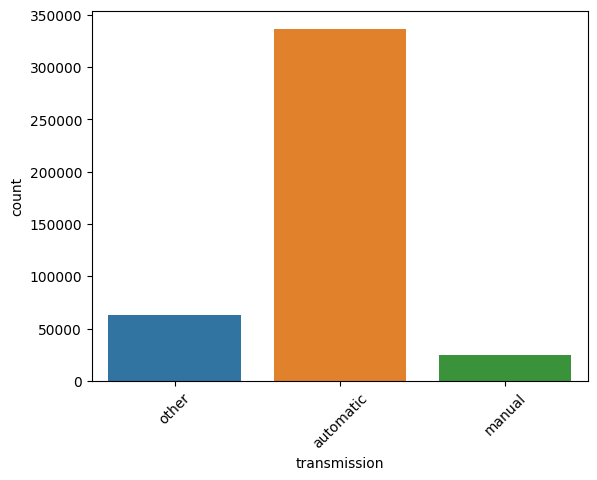

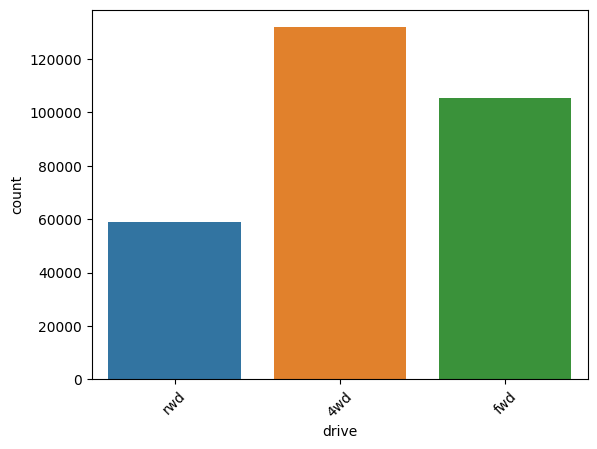

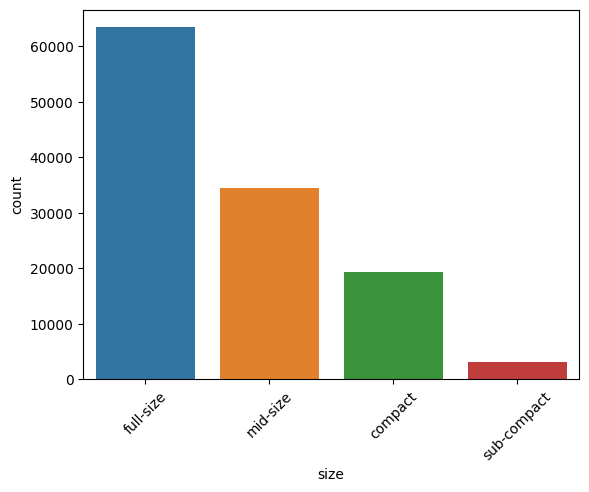

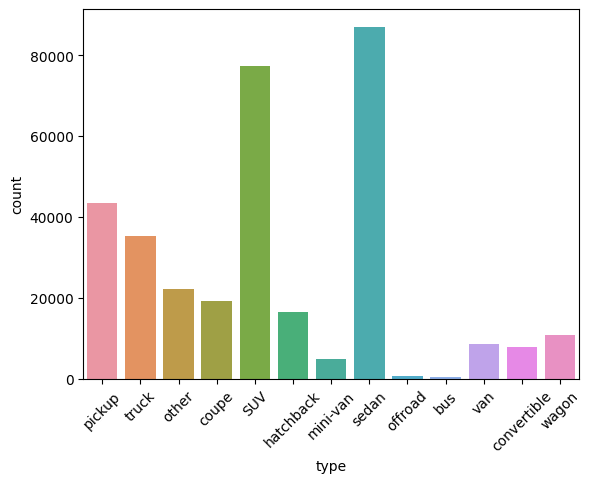

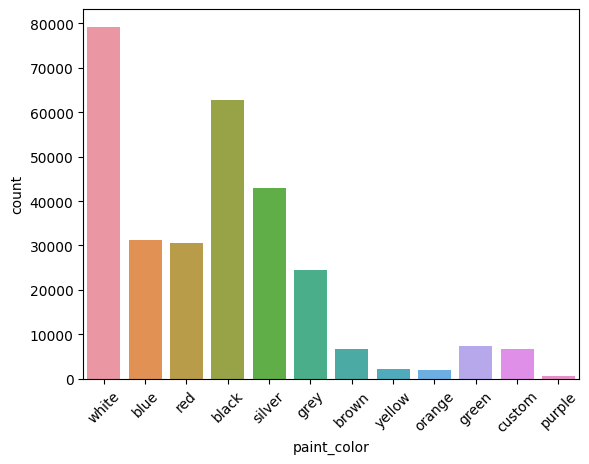

In [ ]:
# categorical features with relatively low cardinality
categorical_vars = [
    'condition',
    'cylinders',
    'title_status',
    'transmission',
    'drive',
    'size',
    'type',
    'paint_color'
]

for cat in categorical_vars:
  sns.countplot(data=df, x=cat)
  plt.xticks(rotation=45)
  plt.show()

**Observations**

* Almost all of the cars sold are in "good" or "excellent" condition
* Very few cars have engines with anything other than four, six or eight cylinders
* Almost all cars sold were owned by the dealer ("clean")
* Sedans and SUVs make up most of the cars sold
* Cars with grayscale colors are the most popular. This is consistent with independent studies published in 2012 by [PPG Industries](https://web.archive.org/web/20121013184631/http://www.ppg.com/en/newsroom/news/Pages/20121010A.aspx) and [DuPont](https://web.archive.org/web/20121229065631/http://www2.dupont.com/Media_Center/en_US/color_popularity/2012_assets.html)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

#### Columns to drop

Both the sale ID and VIN columns can be dropped as they are non-informative.

In [ ]:
df.drop(['id', 'VIN'], axis=1, inplace=True)

An examination of the `region` column shows that it often contains limited or redundant information. In the below example, there are 746 sales where the region is listed as Prescott but does not include the state. Because there are at least [12 places named Prescott in the U.S.](https://en.wikipedia.org/wiki/Prescott#United_States) alone, this information is not helpful without the `state` feature.

In [ ]:
df['region'].unique()

array(['prescott', 'fayetteville', 'florida keys',
       'worcester / central MA', 'greensboro', 'hudson valley',
       'medford-ashland', 'erie', 'el paso', 'bellingham',
       'skagit / island / SJI', 'la crosse', 'auburn', 'birmingham',
       'dothan', 'florence / muscle shoals', 'gadsden-anniston',
       'huntsville / decatur', 'mobile', 'montgomery', 'tuscaloosa',
       'anchorage / mat-su', 'fairbanks', 'kenai peninsula',
       'southeast alaska', 'flagstaff / sedona', 'mohave county',
       'phoenix', 'show low', 'sierra vista', 'tucson', 'yuma',
       'fort smith', 'jonesboro', 'little rock', 'texarkana',
       'bakersfield', 'chico', 'fresno / madera', 'gold country',
       'hanford-corcoran', 'humboldt county', 'imperial county',
       'inland empire', 'los angeles', 'mendocino county', 'merced',
       'modesto', 'monterey bay', 'orange county', 'palm springs',
       'redding', 'reno / tahoe', 'sacramento', 'san diego',
       'san luis obispo', 'santa barbara',

In [ ]:
df.query("region == 'prescott'")['region']

0        prescott
12732    prescott
12733    prescott
12734    prescott
12735    prescott
           ...   
13472    prescott
13473    prescott
13474    prescott
13475    prescott
13476    prescott
Name: region, Length: 746, dtype: object

Furthermore, the `region` feature has high cardinality and could make methods such as one-hot encoding ineffective.

In [ ]:
len(df['region'].unique())

404

It is therefore appropriate to consider dropping this column.

In [ ]:
additional_cols_to_drop = ['region']

A number of issues also affect the `model` feature. For example, the BMW 428i is recorded in multiple formats, but often listed as simply "428i" without additional details:

In [ ]:
df.query("model.notna() and model.str.contains('428i')", engine="python")

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
11287,phoenix,30590,2015.0,bmw,4 series 428i xdrive,good,NaN,gas,30160.0,clean,other,NaN,NaN,other,black,az
12031,phoenix,26990,2015.0,bmw,4 series 428i xdrive,good,NaN,gas,64139.0,clean,other,NaN,NaN,other,blue,az
13389,prescott,26900,2016.0,bmw,428i xdrive,like new,4 cylinders,hybrid,63000.0,clean,automatic,4wd,mid-size,coupe,grey,az
17962,fayetteville,18900,2016.0,bmw,428i,NaN,NaN,gas,149875.0,clean,automatic,NaN,NaN,NaN,NaN,ar
21496,bakersfield,17000,2015.0,bmw,428i gran coupe,excellent,4 cylinders,gas,94000.0,clean,automatic,rwd,NaN,coupe,NaN,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419616,la crosse,20590,2015.0,bmw,4 series 428i gran coupe,good,NaN,gas,65290.0,clean,automatic,NaN,NaN,coupe,black,wi
420140,madison,19000,2014.0,bmw,428i xdrive coupe,excellent,4 cylinders,gas,59100.0,clean,automatic,4wd,mid-size,coupe,black,wi
421727,madison,21590,2014.0,bmw,4 series 428i coupe 2d,good,NaN,gas,63772.0,clean,other,rwd,NaN,coupe,black,wi
425482,sheboygan,21990,2014.0,bmw,4 series 428i xdrive coupe,good,NaN,gas,50293.0,clean,other,NaN,NaN,coupe,blue,wi


In some cases, the data just says "all makes and models" and does not include a specific car.

In [ ]:
df.query("model.notna() and model.str.contains('make')", engine="python")

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
9897,phoenix,500,2014.0,NaN,many makes and models,NaN,NaN,gas,42000.0,clean,automatic,NaN,NaN,NaN,NaN,az
32593,inland empire,1500,2009.0,NaN,Many make and models,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,ca
83367,eastern CT,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,ct
91605,delaware,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,de
91807,delaware,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,de
94283,ft myers / SW florida,1999,2021.0,NaN,All makes,NaN,NaN,gas,99999.0,clean,automatic,NaN,NaN,NaN,NaN,fl
117555,tampa bay area,12345,2018.0,NaN,Any maker,NaN,NaN,other,12345.0,clean,other,NaN,NaN,NaN,NaN,fl
121362,atlanta,999,2012.0,NaN,All makes,excellent,NaN,gas,45000.0,clean,automatic,fwd,NaN,NaN,NaN,ga
122043,atlanta,999,2012.0,NaN,All makes,excellent,NaN,gas,45000.0,clean,automatic,fwd,NaN,NaN,NaN,ga
122359,atlanta,999,2012.0,NaN,All makes,excellent,NaN,gas,45000.0,clean,automatic,fwd,NaN,NaN,NaN,ga


Similar to the `region` feature, this column also has high cardinality and makes one-hot encoding infeasible.

In [ ]:
len(df['model'].unique())

29650

In some cases, information from the `model` column can be used to fill in missing manufacturer data.

In [ ]:
bmw_models = [
    '325i',
    '328i',
    '330i',
    '428i',
    '530i',
    '650i'
]

for car_model in bmw_models:
  i = df.query(f"manufacturer.isna() and model.notna() and model.str.contains('{car_model}')", engine="python").index
  df.loc[i, 'manufacturer'] = 'bmw'

ford_idx = df.query("manufacturer.isna() and model.notna() and model.str.contains('ford')", engine="python").index
df.loc[ford_idx, 'manufacturer'] = 'ford'

 However, this is a time-consuming process and not practical for large data sets. It is therefore reasonable to also drop the `model` column.

In [ ]:
additional_cols_to_drop.append('model')

#### Columns to transform

Because the number of cylinders is in a consistent format for all data points, this data can be converted to a numeric value.

In [ ]:
def n_cylinders(cylinders):
  if type(cylinders) == float:
    if np.isnan(cylinders):
      return np.NaN
    else:
      return cylinders

  cylinders_search = re.search(r'(\d+) cylinders', cylinders)
  if cylinders_search:
    return float(cylinders_search.group(1))
  else:
    return np.NaN

In [ ]:
df['cylinders'] = df['cylinders'].apply(n_cylinders)

In [ ]:
df[['cylinders']].describe()

,cylinders
count,247904.000000
mean,5.968685
std,1.602962
min,3.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,12.000000


#### Other changes

Because outliers could impact the analysis, they first need to be treated. We do so using the following rules:

* Obviously bad data is replaced with the median value
* Data that appears legitimate is clipped
* In ambiguous situations, observations that may or may not be legitimate are given the benefit of the doubt

One method to detect outliers is to define upper and lower control limits based on the interquarter range rule: values below $Q1 - 1.5 \ast IQR$ or above $Q3 + 1.5 \ast IQR$ are considered outliers. We create new columns as follows:

* `adjusted_price`
* `adjusted_mileage`

It is also possible to eliminate outliers using SciPy's `winsorize()` function:

> `new_data = winsorize(data, limits=[0.02, 0.02])`

However, the IQR rule is generally considered to be more resistant to outliers.

In [ ]:
# function to determine upper and lower control limits
def iqr_limits(data):
  q1 = np.quantile(data.dropna(), 0.25, method='midpoint')
  q3 = np.quantile(data.dropna(), 0.75, method='midpoint')
  iqr = q3 - q1
  lower = max(q1 - 1.5 * iqr, 0)
  upper = q3 + 1.5 * iqr
  return lower, upper

We now try to identify a "cut-off point" between bad data and legitimate extreme values.

In [ ]:
df.loc[df['price'].nlargest(50).index]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
318592,eugene,3736928711,2007.0,toyota,tundra,excellent,8.0,gas,164000.0,clean,automatic,4wd,full-size,pickup,silver,or
356716,knoxville,3736928711,1999.0,toyota,4runner,fair,6.0,gas,211000.0,clean,automatic,4wd,mid-size,NaN,green,tn
91576,delaware,3024942282,2000.0,mercedes-benz,benz e320,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,de
257840,south jersey,3024942282,2000.0,mercedes-benz,benz s430,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,nj
37410,modesto,3009548743,2021.0,chevrolet,NaN,NaN,8.0,gas,1000.0,clean,automatic,4wd,NaN,NaN,NaN,ca
184704,frederick,1410065407,1989.0,jeep,wrangler,NaN,NaN,diesel,103000.0,clean,manual,NaN,NaN,SUV,NaN,md
153082,indianapolis,1234567890,2006.0,volvo,vnl,fair,NaN,other,200000.0,clean,manual,NaN,NaN,NaN,black,in
29386,humboldt county,1111111111,1999.0,ford,f350 super duty lariat,good,8.0,diesel,149000.0,clean,automatic,rwd,full-size,pickup,white,ca
37409,modesto,1111111111,2020.0,jeep,NaN,NaN,NaN,gas,1000.0,clean,automatic,4wd,NaN,NaN,NaN,ca
280,birmingham,987654321,1960.0,chevrolet,NaN,NaN,NaN,gas,999999.0,clean,manual,NaN,NaN,NaN,NaN,al


All of the above are for common cars, so the above is repeated with a maximum sale price of $1.2 million.

In [ ]:
df.loc[df[df['price'] < 1200000]['price'].nlargest(30).index]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
26075,fresno / madera,1111111,2014.0,chevrolet,NaN,NaN,NaN,other,11.0,clean,automatic,NaN,NaN,NaN,NaN,ca
213918,minneapolis / st paul,1111111,1999.0,chevrolet,corvette,NaN,NaN,gas,200000.0,clean,automatic,NaN,NaN,NaN,NaN,mn
219241,southwest MS,1111111,1970.0,dodge,challenger,fair,8.0,gas,42000.0,clean,automatic,rwd,full-size,coupe,blue,ms
283429,new hampshire,1111111,1994.0,chevrolet,corvette,NaN,8.0,gas,1111111.0,clean,manual,NaN,NaN,NaN,NaN,nh
356959,memphis,1111111,1966.0,chevrolet,c10,NaN,NaN,gas,111111.0,clean,manual,NaN,NaN,NaN,NaN,tn
83367,eastern CT,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,ct
87052,new haven,1000000,2019.0,NaN,Call for a free estimate,NaN,NaN,gas,12345.0,salvage,automatic,NaN,NaN,NaN,NaN,ct
91605,delaware,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,de
91807,delaware,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,de
232829,charlotte,1000000,2016.0,ford,f150,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,nc


Here, the most expensive sports car sold is a Lamborghini Aventador at \$516,999. The row above it is a Ford F-250 Super Duty XLT Crew Cab listed at \$554,900. We therefore replace sale prices above \$500,000 with the median price and clip the other outliers.

In [ ]:
upper_price_limit = 500000
df['adjusted_price'] = df['price']

bad_prices_idx = df[df['price'] > upper_price_limit].index
df.loc[bad_prices_idx, 'adjusted_price'] = median_price_static

In [ ]:
# adjusted sale price
floor_price, ceil_price = iqr_limits(df["price"])
df["adjusted_price"] = np.clip(df.copy()["adjusted_price"], floor_price, ceil_price)

However, there are also rows that contain unrealistically low prices.

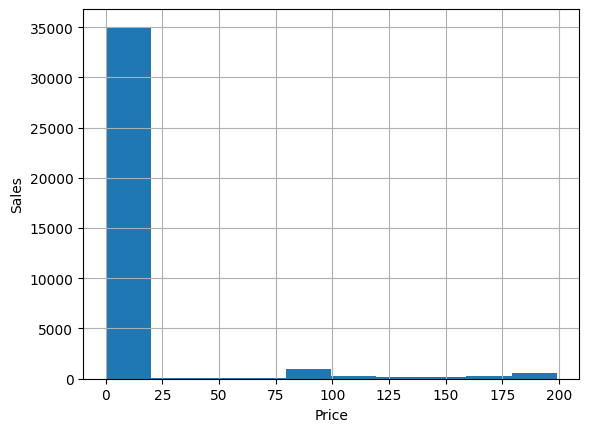

In [ ]:
df[df['price'] < 200]['price'].hist()
plt.xlabel('Price')
plt.ylabel('Sales')
plt.show()

One solution is to replace such prices with the median value if the title is not listed as "salvage" or "parts only."

In [ ]:
lower_price_limit = 200
low_idx = df.query(f"title_status not in ['salvage', 'parts only'] and price < {lower_price_limit}").index
df.loc[low_idx, 'adjusted_price'] = median_price_static

It is more difficult to determine the "cut-off point" for mileage as the outliers are more evenly distributed. Experts have traditionally claimed that cars with more than 100,000 miles are considered risky. We set a limit of 250,000 miles to account for the fact that modern cars are more durable.

In [ ]:
upper_odometer_limit = 250000
df['adjusted_odometer'] = df['odometer']

bad_mileage_idx = df[df['odometer'] > upper_odometer_limit].index
df.loc[bad_mileage_idx, 'adjusted_odometer'] = median_mileage_static

In [ ]:
# adjusted mileage
floor_odometer, ceil_odometer = iqr_limits(df["odometer"])
df["adjusted_odometer"] = np.clip(df.copy()["odometer"], floor_odometer, ceil_odometer)

In [ ]:
additional_cols_to_drop.extend(['price', 'odometer'])

#### Fill missing values

We now replace `NaN` with the median for continuous variables and mode for discrete variables.

In [ ]:
df_cleaned = df.copy()

df_cleaned['year'].fillna(df_cleaned['year'].mode()[0], inplace=True)
df_cleaned['manufacturer'].fillna(df_cleaned['manufacturer'].mode()[0], inplace=True)
df_cleaned['condition'].fillna(df_cleaned['condition'].mode()[0], inplace=True)
df_cleaned['cylinders'].fillna(df_cleaned['cylinders'].mode()[0], inplace=True)
df_cleaned['fuel'].fillna(df_cleaned['fuel'].mode()[0], inplace=True)
df_cleaned['title_status'].fillna(df_cleaned['title_status'].mode()[0], inplace=True)
df_cleaned['transmission'].fillna(df_cleaned['transmission'].mode()[0], inplace=True)
df_cleaned['drive'].fillna(df_cleaned['drive'].mode()[0], inplace=True)
df_cleaned['size'].fillna(df_cleaned['size'].mode()[0], inplace=True)
df_cleaned['type'].fillna(df_cleaned['type'].mode()[0], inplace=True)
df_cleaned['paint_color'].fillna(df_cleaned['paint_color'].mode()[0], inplace=True)
df_cleaned['adjusted_odometer'].fillna(median_mileage_static, inplace=True)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Create training and test sets

In [ ]:
df.drop(additional_cols_to_drop, axis=1, inplace=True)
df_cleaned.drop(additional_cols_to_drop, axis=1, inplace=True)

In [ ]:
test_ratio = 0.3

df_dummies = pd.get_dummies(df_cleaned, drop_first=True)
X = df_dummies.drop('adjusted_price', axis=1)
y = df_dummies['adjusted_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=1)
columns = X.columns

We also keep the original data frame so we can test models that have native support for missing values.

In [ ]:
df_dummies_or = pd.get_dummies(df, drop_first=True)
X_or = df_dummies.drop('adjusted_price', axis=1)

X_train_or, X_test_or, _, _ = train_test_split(X_or, y, test_size=test_ratio, random_state=1)

Create a function to visualize feature importance.

In [ ]:
def feature_importance(model, features=columns, max_features=None):
  importances = model.feature_importances_

  if max_features is not None and type(max_features) == int:
    importance_df = pd.DataFrame(importances, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False).head(max_features)
  else:
    importance_df = pd.DataFrame(importances, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
  plt.figure(figsize=(8, 7))
  sns.barplot(x=importance_df.Importance, y=importance_df.index)
  plt.show()

#### Ridge regression

In [ ]:
%%time
ridge = Ridge(random_state=1)
ridge.fit(X_train, y_train)

CPU times: user 733 ms, sys: 321 ms, total: 1.05 s
Wall time: 762 ms


Ridge(random_state=1)

In [ ]:
y_pred_ridge_train = ridge.predict(X_train)
y_pred_ridge_test = ridge.predict(X_test)

print(f'Training MSE: {mean_squared_error(y_train, y_pred_ridge_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_ridge_test)}')
print(f'Training RMSE: {mean_squared_error(y_train, y_pred_ridge_train, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_ridge_test, squared=False)}')

Training MSE: 82856146.31460364
Test MSE: 82458174.69428758
Training RMSE: 9102.535158657924
Test RMSE: 9080.648363100929


#### Lasso regression

In [ ]:
%%time
lasso = Lasso(random_state=1)
lasso.fit(X_train, y_train)

CPU times: user 36.2 s, sys: 2.85 s, total: 39.1 s
Wall time: 23.6 s


Lasso(random_state=1)

In [ ]:
y_pred_lasso_train = lasso.predict(X_train)
y_pred_lasso_test = lasso.predict(X_test)

print(f'Training MSE: {mean_squared_error(y_train, y_pred_lasso_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_lasso_test)}')
print(f'Training RMSE: {mean_squared_error(y_train, y_pred_lasso_train, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_lasso_test, squared=False)}')

Training MSE: 82945429.97176066
Test MSE: 82520756.26253651
Training RMSE: 9107.438167331176
Test RMSE: 9084.093585082472


#### Hyperparameter tuning with ridge regression

Ridge and lasso regression both give similar results. However, lasso regression is about an order of magnitude slower. We move forward with ridge regression and use `GridSearchCV` to optimize the model.

In [ ]:
alphas = [10 ** n for n in range(-3, 5)]
ridge_params = {'ridge__alpha': alphas}

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=1))
])
ridge_grid = GridSearchCV(estimator=ridge_pipe, param_grid=ridge_params, cv=5)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge(random_state=1))]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                          10000]})

In [ ]:
y_pred_ridge_optimized_train = ridge_grid.predict(X_train)
y_pred_ridge_optimized_test = ridge_grid.predict(X_test)

print(f'Training MSE: {mean_squared_error(y_train, y_pred_ridge_optimized_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_ridge_optimized_test)}')
print(f'Training MSE: {mean_squared_error(y_train, y_pred_ridge_optimized_train, squared=False)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_ridge_optimized_test, squared=False)}')

Training MSE: 82856031.16289866
Test MSE: 82458589.33755635
Training MSE: 9102.528833401115
Test MSE: 9080.671194221071


In [ ]:
ridge_grid.best_params_

{'ridge__alpha': 10}

We can now analyze the coefficients and see how each feature affects the price.


In [ ]:
best_ridge = ridge_grid.best_estimator_
best_ridge_coefs = best_ridge.named_steps['ridge'].coef_
best_ridge_coefs

array([ 2734.70881285,  1560.68727538, -5371.78725448,   122.17346026,
          97.48433714,   244.84427661,  -210.65157293,  -337.68260827,
         -35.70899775,  -297.9573662 ,  -574.68350045,    72.29412877,
        -665.23760171,   251.59048917,  -343.85221159,  -319.35001507,
         126.8597497 ,  -201.77701128,  -466.33499715,  -735.4526131 ,
        -103.03963689,    74.76859148,  -140.67844749,  -685.53545689,
         -38.87052811,   242.42162704,   -18.6302522 ,  -479.90776902,
         -10.0781766 ,  -265.91400863,  -235.53288824,  -576.39794049,
         -19.25542415,  -895.83331382,  -161.20437318,   465.2561769 ,
         117.94743892,   316.6867513 ,  -308.55514077,  -404.61222029,
         649.59379042,    46.62250669,  -691.12344186,    56.95175147,
        -455.80571851,   254.58852965,   220.94395835,   156.85925551,
        -101.27341063,  -890.16681881, -4157.05715672, -1231.92239872,
       -2467.41374305,   124.3884446 ,   -62.80873904,  -166.55589746,
      

In [ ]:
pd.Series(best_ridge_coefs, index=columns)

year                         2734.708813
cylinders                    1560.687275
adjusted_odometer           -5371.787254
manufacturer_alfa-romeo       122.173460
manufacturer_aston-martin      97.484337
                                ...     
state_vt                     -258.735079
state_wa                     -209.773833
state_wi                     -747.358835
state_wv                      -78.414956
state_wy                      -44.808833
Length: 138, dtype: float64

**Observations**

* The optimal value of `alpha` was determined to be 10
* However, the optimized model only gives a small improvement in predictive performance
* The coefficients confirm that higher mileages result in lower sale prices

#### Histogram-based gradient boosting

`HistGradientBoostingRegressor` is an estimator that has native support for missing values. We look at how it performs on the original data frame.

In [ ]:
%%time
gbc = HistGradientBoostingRegressor(random_state=1)
gbc.fit(X_train_or, y_train)

CPU times: user 44.5 s, sys: 252 ms, total: 44.8 s
Wall time: 27 s


HistGradientBoostingRegressor(random_state=1)

In [ ]:
y_pred_train_gbc = gbc.predict(X_train_or)
y_pred_test_gbc = gbc.predict(X_test_or)

print(f'Training MSE: {mean_squared_error(y_train, y_pred_train_gbc)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test_gbc)}')
print(f'Training RMSE: {mean_squared_error(y_train, y_pred_train_gbc, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test_gbc, squared=False)}')

Training MSE: 53319525.924254484
Test MSE: 53451034.221913606
Training RMSE: 7302.022043533865
Test RMSE: 7311.021421245708


#### LightGBM

LightGBM is another estimator that supports missing values. We compare it against the histogram-based gradient boosting regressor.

In [ ]:
%%time
lgbm = lgb.LGBMRegressor(force_row_wise=True, random_state=1)
lgbm.fit(X_train_or, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 298816, number of used features: 135
[LightGBM] [Info] Start training from score 18354.478250
CPU times: user 3.74 s, sys: 145 ms, total: 3.89 s
Wall time: 3.91 s


LGBMRegressor(force_row_wise=True, random_state=1)

In [ ]:
y_pred_train_lgbm = lgbm.predict(X_train_or)
y_pred_test_lgbm = lgbm.predict(X_test_or)

print(f'Training MSE: {mean_squared_error(y_train, y_pred_train_lgbm)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test_lgbm)}')
print(f'Training RMSE: {mean_squared_error(y_train, y_pred_train_lgbm, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test_lgbm, squared=False)}')

Training MSE: 53467211.25914291
Test MSE: 53566474.94966774
Training RMSE: 7312.127683454585
Test RMSE: 7318.912142502309


#### Hyperparameter tuning with LightGBM

`HistGradientBoostingRegressor` and LightGBM both outperform ridge regression and give similar results. However, LightGBM is much faster and takes a fraction of the time to run. `GridSearchCV` is used to determine whether LightGBM can be further optmized.

In [ ]:
# note: this takes a long time to run!
%%time
lgb_estimator = lgb.LGBMRegressor(force_row_wise=True, random_state=1)

params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 150, 300, 600, 900]
    }

lgb_grid = GridSearchCV(lgb_estimator, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train_or, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 298816, number of used features: 135
[LightGBM] [Info] Start training from score 18354.478250
CPU times: user 26 s, sys: 2.08 s, total: 28.1 s
Wall time: 14min 23s


GridSearchCV(cv=5, estimator=LGBMRegressor(force_row_wise=True, random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [50, 100, 150, 300, 600, 900]},
             scoring='neg_mean_squared_error')

In [ ]:
y_pred_lgbm_optimized_train = lgb_grid.predict(X_train_or)
y_pred_lgbm_optimized_test = lgb_grid.predict(X_test_or)

print(f'Training MSE: {mean_squared_error(y_train, y_pred_lgbm_optimized_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_lgbm_optimized_test)}')
print(f'Training RMSE: {mean_squared_error(y_train, y_pred_lgbm_optimized_train, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_lgbm_optimized_test, squared=False)}')

Training MSE: 38398204.730124235
Test MSE: 41610979.09739913
Training RMSE: 6196.628497023542
Test RMSE: 6450.6572608842835


**Observations**

Hyperparameter tuning for LightGBM is computationally intensive, but optimized model shows further improvements. We present this model as a candidate for production use.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Selected model: LightGBM

In [ ]:
lgb_best_model = lgb_grid.best_estimator_
lgb_best_model

LGBMRegressor(force_row_wise=True, n_estimators=900, random_state=1)

In [ ]:
lgb_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 900}

The optimal model uses a `learning_rate` of 0.1 and 900 trees.

Because LightGBM uses an ensemble of decision trees, there are no "coefficients" like normal regression models. However, LightGBM supports a `feature_importances_` attribute that can be used to visualize feature importances. We look at the most and least important features.

In [ ]:
lgb_importances = lgb_best_model.feature_importances_
pd.DataFrame(lgb_importances, index=columns, columns=['Importance']).sort_values(by='Importance', ascending=False).head(30)

,Importance
adjusted_odometer,6346
year,4456
cylinders,1355
type_sedan,803
transmission_other,792
fuel_gas,787
condition_good,782
drive_fwd,716
paint_color_white,711
manufacturer_ford,613


In [ ]:
pd.DataFrame(lgb_importances, index=columns, columns=['Importance']).sort_values(by='Importance', ascending=False).tail(30)

,Importance
title_status_lien,21
paint_color_orange,21
manufacturer_harley-davidson,21
state_al,20
state_vt,19
manufacturer_mercury,19
type_offroad,19
state_ri,19
manufacturer_saturn,19
title_status_parts only,19


The adjusted mileage and the model year have the largest effect on the sale price. The model year can be used to calculate the vehicle's age, which is expected to be positively correlated with the mileage. Because this is consistent with industry trends as well as common sense, the model is likely fairly solid.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Findings

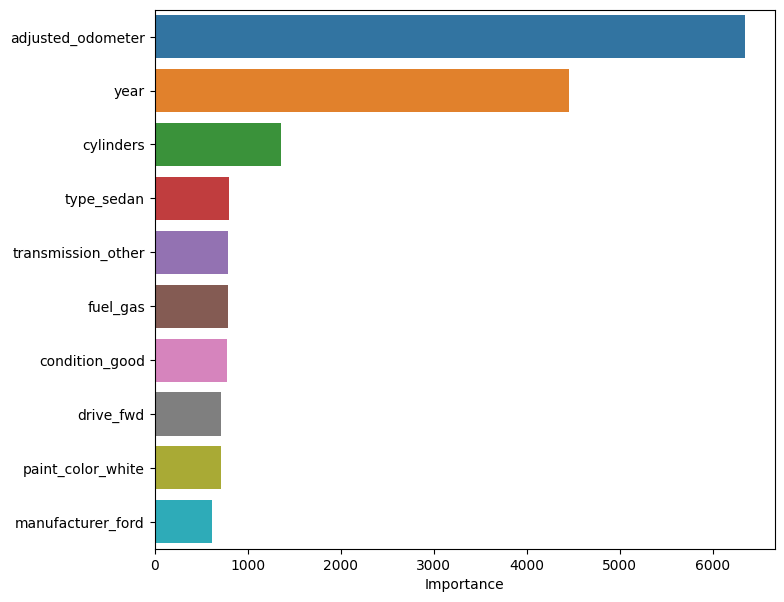

In [ ]:
feature_importance(lgb_best_model, max_features=10)

From the top features that affect the sale price, the following can be concluded:

* The model confirms that mileage has the largest effect on sales price
* The car's model year is also an important feature. This is not unexpected because older cars tend to have more mileage
* The number of cylinders in the engine is also a significant factor

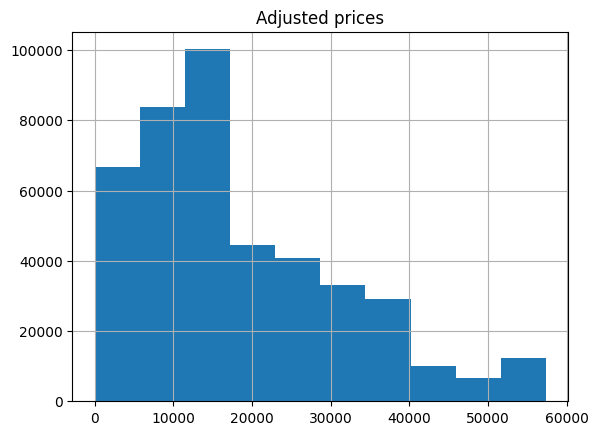

In [ ]:
df['adjusted_price'].hist()
plt.title("Adjusted prices")
plt.show()

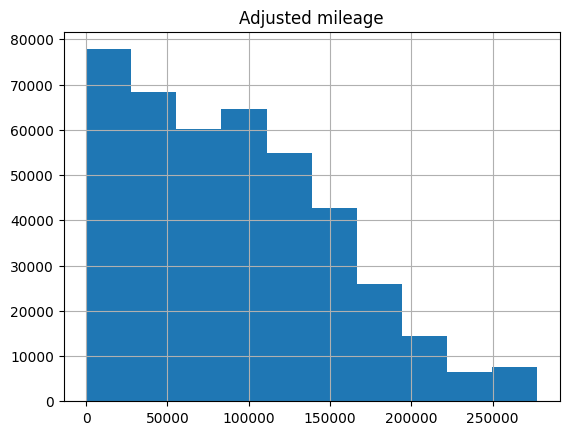

In [ ]:
df['adjusted_odometer'].hist()
plt.title("Adjusted mileage")
plt.show()

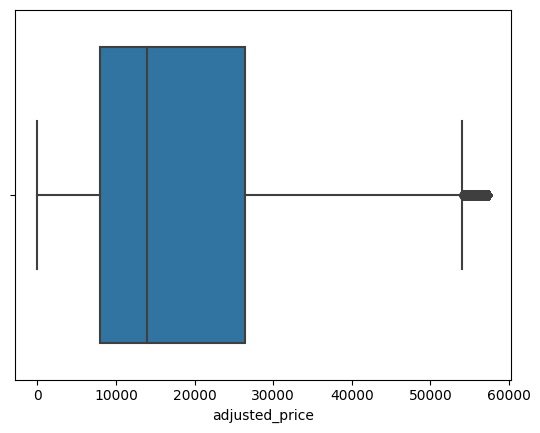

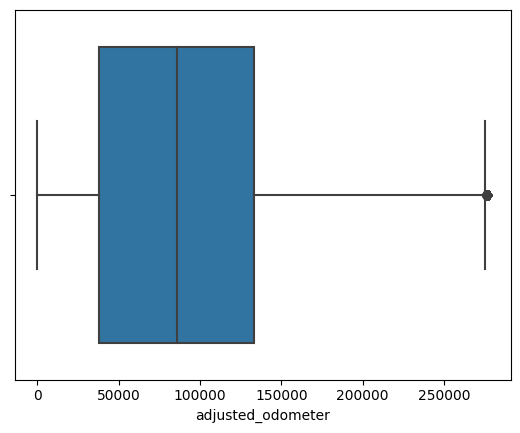

In [ ]:
adjusted_vars = ['adjusted_price', 'adjusted_odometer']
for var in adjusted_vars:
  sns.boxplot(data=df_cleaned, x=var)
  plt.show()

In [ ]:
df_cleaned[adjusted_vars].describe()

,adjusted_price,adjusted_odometer
count,426880.000000,426880.000000
mean,18350.580492,91457.004334
std,13209.656183,62735.484137
min,0.000000,0.000000
25%,7995.000000,38130.000000
50%,13950.000000,85548.000000
75%,26401.250000,133000.000000
max,57366.250000,277303.000000


The average used car is sold for $18,350 and has a mileage of 91,457 miles on average, after treatment of outliers.

Here is a correlation heat map of the adjusted price, adjusted mileage and number of cylinders. A negative correlation exists between the price and mileage; this confirms cars with more mileage are generally sold for less.

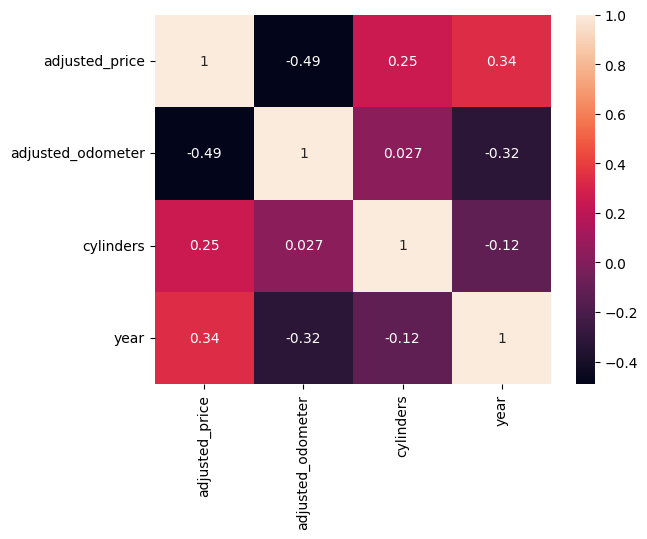

In [ ]:
sns.heatmap(df_cleaned[['adjusted_price', 'adjusted_odometer', 'cylinders', 'year']].corr(), annot=True)
plt.show()

#### Recommendations

* Used car dealers should focus on acquisition of cars with low mileage as those tend to be worth more
  * Older cars are naturally expected to have higher mileage and sell for less
* Other attributes that increase a car's value include:
  * Having more cylinders
  * Is a sedan
  * Good condition
  * Uses gasoline as fuel
  * Ford make

#### Additional information that can be collected to gain better insights

It may be useful to collect additional data that could be used in future models:

* Whether or not the vehicle was involved in any accidents. In many cases, dealerships are legally required to disclose this information
* The price at which the dealer bought the car from the original owner. This information can be used to identify sales with a high profit martin
* A categorical variable indicating the reason the original owner sold the car to the dealership
* The buyer's income. Individuals with lower incomes may try to negotiate a reduced price